Define our imports

In [1]:
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential #Initialise our neural network model as a sequential network
from tensorflow.keras.layers import Conv2D #Convolution operation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation#Applies activation function
from tensorflow.keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from tensorflow.keras.layers import MaxPooling2D # Maxpooling function
from tensorflow.keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from tensorflow.keras.layers import Dense # Regular fully connected neural network
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

For the FER dataset, this script loads images into training, testing, and validation data, 

In [ ]:
def load_data(dataset_path):
  
  classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']  #We will be dealing with seven different types of emotions.

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)#Creating a list out of the string then converting it into a 2-Dimensional numpy array.
            image_data =image_data.astype(np.uint8)/255.0
            
            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)


<font size=14pt>EMOTION CLASSIFICATION </font> 

In [ ]:
dataset_path = "~MTSU/csci4850-NeuralNets/proj/archive (2)/fer2013.csv" 
train_data, train_labels, test_data, test_labels = load_data(dataset_path)

print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))

Number of images in Training set: 32298
Number of images in Test set: 3589


DEFINE OUR MODEL

In [ ]:
#######HYPERPARAMATERS###########
epochs = 100
batch_size = 64
learning_rate = 0.001
#################################

model = Sequential()
    
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
adam = optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())

learning_mod = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, mode='auto')
cp = ModelCheckpoint('~MTSU/csci4850-NeuralNets/proj/Model/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        3

TRAIN THE DATA FOR THE EMOTION MODEL

In [ ]:
history = model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True,
#          callbacks=[learning_mod, cp, stop]
          callbacks=[learning_mod, cp]

#          callbacks=[learning_mod]
          )

Epoch 1/100
404/404 [==============================] - ETA: 0s - loss: 1.9506 - accuracy: 0.2076
Epoch 1: val_loss improved from inf to 1.84404, saving model to /content/My Drive/Colab Notebooks/Emotion Recognition/Model\weights.hd5
INFO:tensorflow:Assets written to: /content/My Drive/Colab Notebooks/Emotion Recognition/Model\weights.hd5\assets
404/404 [==============================] - 186s 460ms/step - loss: 1.9506 - accuracy: 0.2076 - val_loss: 1.8440 - val_accuracy: 0.2489 - lr: 0.0010
Epoch 2/100
404/404 [==============================] - ETA: 0s - loss: 1.8564 - accuracy: 0.2374
Epoch 2: val_loss improved from 1.84404 to 1.84207, saving model to /content/My Drive/Colab Notebooks/Emotion Recognition/Model\weights.hd5
INFO:tensorflow:Assets written to: /content/My Drive/Colab Notebooks/Emotion Recognition/Model\weights.hd5\assets
404/404 [==============================] - 185s 457ms/step - loss: 1.8564 - accuracy: 0.2374 - val_loss: 1.8421 - val_accuracy: 0.2489 - lr: 0.0010
Epoch 

In [ ]:
predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))

Accuracy score =  0.6140986347171914


In [ ]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("~MTSU/csci4850-NeuralNets/proj/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("~MTSU/csci4850-NeuralNets/proj/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
epochs = 10
batch_size = 64

In [ ]:
history = model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True,
#          callbacks=[lr_reducer, checkpointer, early_stopper]
          callbacks=[lr_reducer, checkpointer]

#          callbacks=[lr_reducer, early_stopper]
          )

Epoch 1/10
404/404 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.6452
Epoch 1: val_loss did not improve from 1.11792
404/404 [==============================] - 257s 636ms/step - loss: 0.9678 - accuracy: 0.6452 - val_loss: 1.1217 - val_accuracy: 0.6176 - lr: 2.2877e-04
Epoch 2/10
404/404 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.6468
Epoch 2: val_loss did not improve from 1.11792
404/404 [==============================] - 278s 688ms/step - loss: 0.9604 - accuracy: 0.6468 - val_loss: 1.1201 - val_accuracy: 0.6153 - lr: 2.2877e-04
Epoch 3/10
404/404 [==============================] - ETA: 0s - loss: 0.9517 - accuracy: 0.6522
Epoch 3: val_loss improved from 1.11792 to 1.11555, saving model to /content/My Drive/Colab Notebooks/Emotion Recognition/Model\weights.hd5
INFO:tensorflow:Assets written to: /content/My Drive/Colab Notebooks/Emotion Recognition/Model\weights.hd5\assets
404/404 [==============================] - 287s 711ms/step -

<font size=14pt>DOG CLASSIFICATION MODEL </font> 

In [2]:
# First a few tools for this -particular- example...
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

<font size=4pt>This scripts LOADS DATA for the DOG AND CAT datasets </font> 

In [3]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


In [90]:
dog_X = np.concatenate(
 [grab_image('dog_images/dog_%d.jpg'%(i))
 for i in range(50)])
dog_X.shape

(50, 299, 299, 3)

Loaded with images of dogs

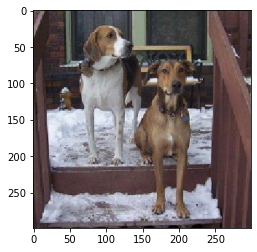

In [91]:
plt.imshow(image.array_to_img(dog_X[0,:,:,:]))
plt.show()

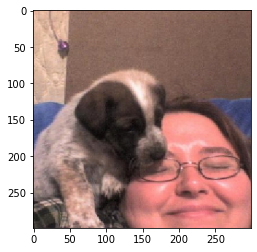

In [92]:
plt.imshow(image.array_to_img(dog_X[1,:,:,:]))
plt.show()

In [93]:
# Let's load up the model 
# This will load up the architecture
# and then the pre-trained weights from the
# from GOOGLE IMAGENET 
dog_model = Xception(weights='imagenet')
dog_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [94]:
# Just the first image that we say above...
dog_preds = dog_model.predict(dog_X[0:1,:,:,:])
# Decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(dog_preds, top=5)[0])

Predicted: [('n02089973', 'English_foxhound', 0.41957986), ('n02089867', 'Walker_hound', 0.368481), ('n02090379', 'redbone', 0.04058074), ('n02088364', 'beagle', 0.026617622), ('n02088466', 'bloodhound', 0.011839185)]


In [95]:
# dogs in there (7 categories)
dog_Y = np.loadtxt('dog_images/dog_types.csv')
# Take a look at the first 10...
dog_Y[0:10]

array([1., 1., 3., 2., 3., 6., 4., 0., 1., 1.])

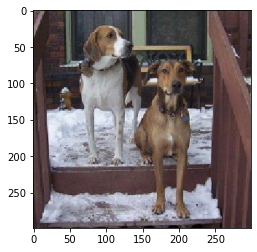

In [96]:
plt.imshow(image.array_to_img(dog_X[0,:,:,:]))
plt.show()

SHAPE OF DATASET

In [97]:
(dog_x_train,dog_y_train),(dog_x_test,dog_y_test) = (dog_X,dog_Y[0:50]),(dog_X,dog_Y[0:50])

display(dog_x_train.shape)
display(dog_y_train.shape)
display(dog_x_test.shape)
display(dog_x_test.shape)

(50, 299, 299, 3)

(50,)

(50, 299, 299, 3)

(50, 299, 299, 3)

In [98]:
dog_x_train, dog_x_valid, dog_y_train, dog_y_valid = train_test_split(dog_x_train,dog_y_train, train_size=0.8)

In [99]:
display(dog_x_train.shape)
display(dog_y_train.shape)
display(dog_x_test.shape)
display(dog_x_test.shape)

(40, 299, 299, 3)

(40,)

(50, 299, 299, 3)

(50, 299, 299, 3)

In [100]:
#!pip install pydot
#!pip install graphviz
import pydot
import graphviz

DEFINE OUR MODEL FOR DOG CLASSIFICATION

In [101]:
# General parameters
img_rows = dog_x_train.shape[1]
img_cols = dog_x_train.shape[2]
channels = dog_x_train.shape[3]
img_shape = (img_rows, img_cols, channels)
num_classes = len(np.unique(dog_y_train))
latent_dim = 150 # You choose - lower than image size

In [105]:
dog_x = keras.layers.Input(dog_x_train.shape[1:])

dog_y = dog_x
dox_y = keras.layers.Embedding(num_classes, latent_dim)(dog_y)
dog_y = keras.layers.Conv2D(32, kernel_size=(4,4), activation='relu')(dog_y)
dog_y = keras.layers.Dropout(0.25)(dog_y)
dog_y = keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu')(dog_y)
dog_y = keras.layers.Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), activation='relu')(dog_y)
dog_y = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(dog_y)
dog_y = keras.layers.MaxPool2D(pool_size=(2,2))(dog_y)
dog_y = keras.layers.LeakyReLU(alpha=0.2)(dog_y)
dog_y = keras.layers.Dropout(0.25)(dog_y)
dog_y = keras.layers.BatchNormalization(momentum=0.8)(dog_y)
dog_y = keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2),
                                           padding='same')(dog_y)
dog_y = keras.layers.LeakyReLU(alpha=0.2)(dog_y)
dog_y = keras.layers.Dropout(0.25)(dog_y)
dog_y = keras.layers.BatchNormalization(momentum=0.8)(dog_y)
dog_y = keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,2),
                                           padding='same')(dog_y)
dog_y = keras.layers.LeakyReLU(alpha=0.2)(dog_y)
dog_y = keras.layers.Dropout(0.25)(dog_y)
dog_y = keras.layers.Flatten()(dog_y)

dog_y = keras.layers.Dropout(0.25)(dog_y)
# Output Logits (10)
dog_y = keras.layers.Dense(128, activation='relu')(dog_y)
dog_y = keras.layers.Dense(len(np.unique(dog_y_train)))(dog_y)
dog_model = keras.Model(dog_x,dog_y)
dog_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=0.0004),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
dog_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 conv2d_61 (Conv2D)          (None, 296, 296, 32)      1568      
                                                                 
 dropout_44 (Dropout)        (None, 296, 296, 32)      0         
                                                                 
 conv2d_62 (Conv2D)          (None, 293, 293, 128)     65664     
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 588, 588, 32)     65568     
 ranspose)                                                       
                                                                 
 zero_padding2d_9 (ZeroPaddi  (None, 589, 589, 32)     0         
 ng2D)                                                    

TRAIN THE DOG MODEL

In [106]:
dog_dg = keras.preprocessing.image.ImageDataGenerator(
  width_shift_range=0.05,
  height_shift_range=0.05,
  rotation_range=0,
  zoom_range=0,
  horizontal_flip=False)
dog_dg_trainer = dog_dg.flow(dog_x_train,
                        dog_y_train,
                        batch_size=5)

In [107]:
# TRAIN DATA
dog_epochs = 20
dog_history = dog_model.fit(dog_dg_trainer,
                            epochs=dog_epochs,
                            verbose=1,
                            validation_data=(dog_x_valid,dog_y_valid))

Epoch 1/20
8/8 [==============================] - 18s 2s/step - loss: 8.7488 - sparse_categorical_accuracy: 0.1000 - val_loss: 3.4256 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/20
8/8 [==============================] - 18s 2s/step - loss: 5.3003 - sparse_categorical_accuracy: 0.1750 - val_loss: 2.8223 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 20s 3s/step - loss: 2.5204 - sparse_categorical_accuracy: 0.3500 - val_loss: 3.8225 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/20
8/8 [==============================] - 23s 3s/step - loss: 1.2706 - sparse_categorical_accuracy: 0.5500 - val_loss: 5.2666 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/20
8/8 [==============================] - 23s 3s/step - loss: 0.7656 - sparse_categorical_accuracy: 0.8000 - val_loss: 5.9955 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/20
8/8 [==============================] - 23s 3s/step - loss: 0.5120 - sparse_categorical_accuracy: 0.82

In [108]:
# Final Result - Generalization!
dog_score = dog_model.evaluate(dog_x_valid, dog_y_valid, verbose=1)
print('Test loss:', dog_score[0])
print('Test accuracy:', dog_score[1])

1/1 [==============================] - 1s 1s/step - loss: 11.4207 - sparse_categorical_accuracy: 0.2000
Test loss: 11.420741081237793
Test accuracy: 0.20000000298023224


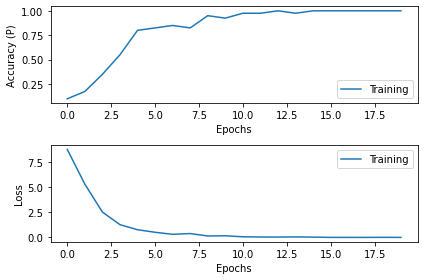

In [109]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(dog_history.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('Accuracy (P)')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
# summarize history for loss

plt.subplot(212)
plt.plot(dog_history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

<font size=14pt>CAT MODEL </font> 

In [4]:
# This part will be the input for the model later on, passing images into the model for the model to be processed
cat_X = np.concatenate(
 [grab_image('cat_dataset/cat_images/cat_%d.jpg'%(i))
 for i in range(150)])
cat_X.shape

(150, 299, 299, 3)

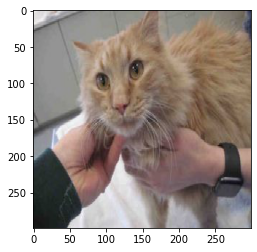

In [5]:
#Prints out first picture of a cat, this one is a long-haired one (class 2).
plt.imshow(image.array_to_img(cat_X[0,:,:,:]))
plt.show()

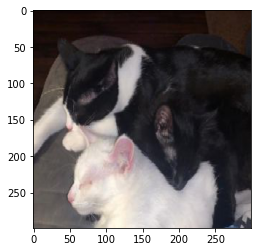

In [6]:
# Prints out the second picture, this one is a short-haired cat (class 0).
plt.imshow(image.array_to_img(cat_X[1,:,:,:]))
plt.show()

In [7]:
# Let's load up the model
# This will load up the architecture
# and then the pre-trained weights from the
# internet...
cat_model = Xception(weights='imagenet')
cat_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [8]:
# Just the first image that we say above...
cat_preds = cat_model.predict(cat_X[0:1,:,:,:])
# Decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(cat_preds, top=5)[0])

Predicted: [('n02123159', 'tiger_cat', 0.5722902), ('n02123045', 'tabby', 0.14365956), ('n02124075', 'Egyptian_cat', 0.04088893), ('n02127052', 'lynx', 0.039072923), ('n02123394', 'Persian_cat', 0.009324582)]


In [9]:
# 150 cats in there (3 Categories)
cat_Y = np.loadtxt('cat_dataset/cat_data.csv')
# Take a look at the first 10...
cat_Y[0:10]

array([2., 0., 1., 0., 0., 0., 2., 1., 1., 0.])

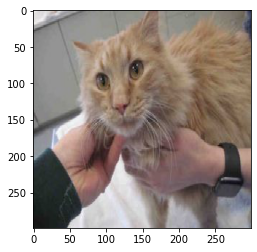

In [10]:
# Again so you can see that the image is of a long-haired cat (classified correctly as 2)
plt.imshow(image.array_to_img(cat_X[0,:,:,:]))
plt.show()

In [12]:
(cat_X_train,cat_Y_train),(cat_X_test,cat_Y_test) = (cat_X,cat_Y[0:150]),(cat_X,cat_Y[0:150])

display(cat_X_train.shape)
display(cat_Y_train.shape)
display(cat_X_test.shape)
display(cat_Y_test.shape)

(150, 299, 299, 3)

(150,)

(150, 299, 299, 3)

(150,)

In [13]:
# Where we decide how much are we going to use to train the model and how much is used only for validation - here 
# we use 80% for training and the remaining 20% are the images the model has not seen before for validation
cat_x_train, cat_x_valid, cat_y_train, cat_y_valid = train_test_split(cat_X_train,cat_Y_train, train_size=0.8)

In [14]:
# This is where we create the model for training, will print out the summary for the model (how many layers it has and parameters)

cat_x = keras.layers.Input(cat_x_train.shape[1:])
cat_y = cat_x
cat_y = keras.layers.Conv2D(64, kernel_size=(4,4), activation='relu')(cat_y)
cat_y = keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu')(cat_y)
cat_y = keras.layers.MaxPooling2D(pool_size=(4,4))(cat_y)
cat_y = keras.layers.Dropout(0.25)(cat_y)
cat_y = keras.layers.Conv2D(128, kernel_size=(4,4), activation='relu')(cat_y)
cat_y = keras.layers.Flatten()(cat_y)
cat_y = keras.layers.Dropout(0.5)(cat_y)
# Output Logits (10)
cat_y = keras.layers.Dense(len(np.unique(cat_y_train)))(cat_y)
cat_model = keras.Model(cat_x,cat_y)
cat_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=0.0004),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
cat_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 296, 296, 64)      3136      
                                                                 
 conv2d_5 (Conv2D)           (None, 293, 293, 128)     131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 70, 70, 128)       262272    
                                                             

In [15]:
# This code will provide different transformations for each image so that it can work with different images better 
cat_dg = keras.preprocessing.image.ImageDataGenerator(
  width_shift_range=0.05,
  height_shift_range=0.05,
  rotation_range=0,
  zoom_range=0,
  horizontal_flip=False)
cat_dg_trainer = cat_dg.flow(cat_x_train,
                        cat_y_train,
                        batch_size=4)

In [16]:
# TRAIN DATA
# This code will train the model, will train 20 epochs and try to measure training and validation accuracy of the model.
cat_epochs = 20
cat_history = cat_model.fit(cat_dg_trainer,
                            epochs=cat_epochs,
                            verbose=1,
                            validation_data=(cat_x_valid,cat_y_valid))

Epoch 1/20
30/30 [==============================] - 32s 1s/step - loss: 1.1993 - sparse_categorical_accuracy: 0.3500 - val_loss: 1.0994 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/20
30/30 [==============================] - 34s 1s/step - loss: 1.0991 - sparse_categorical_accuracy: 0.4083 - val_loss: 1.1087 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/20
30/30 [==============================] - 33s 1s/step - loss: 1.0835 - sparse_categorical_accuracy: 0.4083 - val_loss: 1.2755 - val_sparse_categorical_accuracy: 0.1333
Epoch 4/20
30/30 [==============================] - 33s 1s/step - loss: 1.0411 - sparse_categorical_accuracy: 0.4083 - val_loss: 1.4992 - val_sparse_categorical_accuracy: 0.2000
Epoch 5/20
30/30 [==============================] - 33s 1s/step - loss: 0.9629 - sparse_categorical_accuracy: 0.5417 - val_loss: 1.4916 - val_sparse_categorical_accuracy: 0.1667
Epoch 6/20
30/30 [==============================] - 32s 1s/step - loss: 0.9404 - sparse_categorical_accuracy: 

In [17]:
# Final Result - Generalization!
# Will evaluate the model for the training accuracy/loss
cat_score = cat_model.evaluate(cat_X_test, cat_Y_test, verbose=1)
print('Test loss:', cat_score[0])
print('Test accuracy:', cat_score[1])

5/5 [==============================] - 7s 1s/step - loss: 0.5979 - sparse_categorical_accuracy: 0.8533
Test loss: 0.5979112386703491
Test accuracy: 0.8533333539962769


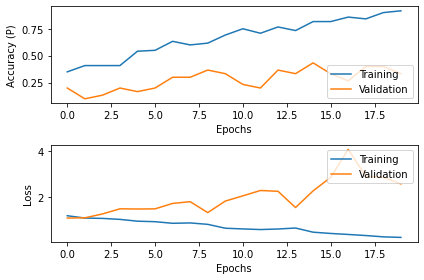

In [18]:
#These plots will graph the accuracy calculated from above so you can see if the model improved over time or not. 

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(cat_history.history['sparse_categorical_accuracy'])
plt.plot(cat_history.history['val_sparse_categorical_accuracy'])
plt.ylabel('Accuracy (P)')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
# summarize history for loss

plt.subplot(212)
plt.plot(cat_history.history['loss'])
plt.plot(cat_history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()